Adaptive 3D LUT - All Loss included
==============

## 1. Abstract
현재 내가 맡은 파트는 Image-Adaptive-3DLUT 프로그램을 적절하게 수정하여, 현 최신 버전의 Cuda 및 Pytorch 등과 호환되도록 만들고, 저조도 image를 고조도 image로 바꾸는 작업을 AI model을 통해 수행하는 것이 목표다.
또한, 이를 Jupyter Notebook 파일인 .ipynb로 이를 작성하여, 내가 작성한 코드와 준비 과정 기록의 가독성을 높이는 것을 주 목적으로 이 파일을 작성한다.

### 1.1 Requirements (For Manual)
내가 현재 사용중인 컴퓨터 사양 및, 필요한 프로그램과 패키지들의 설치, Python 가상환경 생성 등에 대해 다룬다.

해당 코드를 가상 환경에서 실행하면, 내가 사용중인 모듈들과 정확히 동일한 버전의 Python 패키지들을 다운로드 받을 수 있다.

이전에, **반드시 Python installation 과정에서 Add PATH 항목을 체크하고 넘어갈 것.** (설치 과정 사진 첨부 必)

아래 코드들은, Python 3.10.4, Windows 11 64bit 환경의 Windows Powershell에서 진행된다고 가정한다.




In [35]:
cd C:\Users\Username # Username 필드에 자신의 Username을 입력한다. 
python -m venv title # Title 필드에 자신의 가상항목 이름을 입력한다.
.\venv\Scripts\activate # 가상환경 활성화 코드

SyntaxError: invalid syntax (393043472.py, line 1)

In [ ]:

### CUDA 12.1, 12.6 Capable
numpy == 1.26.4
pytorch --index-url https://download.pytorch.org/whl/cu126
torchvision --index-url https://download.pytorch.org/whl/cu126
Pillow == 9.5.0
opencv-python == 4.8.0.76
scipy == 1.15.3
ninja == 1.11.1.4
imageio == 2.37.0
kornia == 0.8.1
wheel == 0.45.1
tqdm == 4.67.1

pip install rawpy==0.25.0 # 만약 .dng와 같이 raw file을 .jpg와 같은 파일 형식으로 convert하려면 필요.



## 2. Parameters
아래는 지금부터 실행할 모든 파일에서 사용되는 Parameter들이 기록되어 있고, 이를 수정할 수 있게 설정했다.



In [11]:
import argparse

parser = argparse.ArgumentParser()

#################### Model Parameters #######################

################### Dataset Parameters ######################

parser.add_argument("--min_dist", type=int, default=480, help="가로와 세로 중 상대적으로 짧은 곳을 480p로 설정 후, 비율에 맞게 리사이징합니다.")

#################### Training Parameters ####################

parser.add_argument("--epoch", type=int, default=85, help="start epoch")
parser.add_argument("--n_epochs", type=int, default=400, help="total epochs")
parser.add_argument("--dataset_name", type=str, default="fiveK", help="dataset name")
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--lr", type=float, default=1e-6, help="Learning Rate")
parser.add_argument("--b1", type=float, default=0.9)
parser.add_argument("--b2", type=float, default=0.999)
parser.add_argument("--n_cpu", type=int, default=12, help="The number of CPU threads to train model.") 
parser.add_argument("--output_dir", type=str, default="RGB_LUT_Classifier_Ckpt")
parser.add_argument("--lambda_ssim", type=float, default=5, help="The Lambda of SSIM Loss")
parser.add_argument("--lambda_mse", type=float, default = 10, help="The Lambda of MSE Loss")
parser.add_argument("--lambda_color", type=float, default=1, help="The Lambda of CIEDE2000 Loss")
parser.add_argument("--2000_eps_value", type=float, default=3e-4, help="일부 이미지에서 NaN이 뜨는 현상 방지를 위한 eps 값 설정. 가급적이면 1e-4 이상을 강력히 권장합니다.")
parser.add_argument("--lambda_smooth", type=float, default=0.01, help="smooth regularization")
parser.add_argument("--lambda_monotonicity", type=float, default=0.01, help="monotonicity regularization")
parser.add_argument("--norm", type=str, default="instance", choices=["instance","batch","none"], help="normalization type used in Classifier")

#################### Evaluation Parameters ####################

parser.add_argument("--inf_epoch", type=int, default=22)
parser.add_argument("--model_dir", type=str, default="RGB_LUT_Classifier_Ckpt")
parser.add_argument("--num_workers_eval", type=int, default=0)  # Windows면 0 권장



opt, _= parser.parse_known_args()



## 3. AI model structure
이 항목에서는 AI model을 구성하는데 필요한 코드들이 적혀있다. LUT, Trilinear, Total Variation Loss 및 Monotonic Loss 등 여러 기능을 관리할 수 있다.

바로 아래에는 기본 weights 설정과 디버깅 관련 코드, 모드에 따른 Normalization을 선택할 수 있는 코드이다. 가급적이면 normalization은 건드리지 말 것.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import kornia.color as K
import trilinear_c__ext as trilinear_ext

# ---------------------- normalization2D 관련 ---------------------- 

def get_norm2d(num_features: int, norm_type: str = "instance"):

    if norm_type == "batch":
        return nn.BatchNorm2d(num_features)  # running stats ON by default
    elif norm_type == "instance":
        return nn.InstanceNorm2d(num_features, affine=True, track_running_stats=False)
    elif norm_type == "none":
        return nn.Identity()
    else:
        raise ValueError(f"Unsupported norm_type: {norm_type}")


# ---------------------- Debugging 및 Parameter ---------------------- 

torch.autograd.set_detect_anomaly(True)


# ----------------------  Weight 관련 ---------------------- 

def weights_init_normal_classifier(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
    elif classname.find("BatchNorm2d") != -1 or classname.find("InstanceNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)



아래에는 Trilinear Interpolation에 관련된 Class들이 정의되어 있습니다. 기존 코드와 가장 큰 차이점들이라면 메모리의 contiguity를 보장하여 최신 Pytorch 및 Cuda에 대응할 수 있게 수정한 것이며, 나머지는 정적 메소드 @staticmethod를 사용하여 parameter들의 상속과 관련된 문제를 해결했다는 것입니다.

이 함수는 Parameter들을 지정하고 c++ 파일에서 정의된 trilinear_ext 모듈을 사용하여  연산을 수행합니다. 여기서 RGB pixel이 LUT에 Mapping되며,
backward 단에서는 forward 단에서 Parameter들을 받고, grad_LUT = torch.zeros_like를 이용하여 미리 gradient 값을 0으로 초기화합니다. 이후 trilinear_ext 모듈을 사용하여 LUT들의 Gradient을 구하는 연산을 수행합니다. 




In [13]:
class TrilinearInterpolation(Function):
    @staticmethod
    def forward(ctx, LUT, x):  # 3D LUT
        x_cont   = x.contiguous()
        LUT_cont = LUT.contiguous()

        B, C, H, W = x_cont.shape
        dim     = LUT_cont.size(1)

        shift   = dim ** 3
        binsize = 1.0 / (dim - 1)

        # CUDA 바인딩 호출 (qforward)
        output = trilinear_ext.forward(
            LUT_cont, x_cont,
            dim, shift, binsize,
            W, H, B
        )

        # backward용 저장
        ctx.save_for_backward(x_cont, LUT_cont)
        ctx.dim      = dim
        ctx.shift    = shift
        ctx.binsize  = binsize
        ctx.W        = W
        ctx.H        = H
        ctx.B        = B

        return output

    @staticmethod
    def backward(ctx, grad_output):
        x, LUT = ctx.saved_tensors
        dim      = ctx.dim
        shift    = ctx.shift
        binsize  = ctx.binsize
        W, H, B= ctx.W, ctx.H, ctx.B

        grad_output = grad_output.contiguous()

        # backward는 LUT에 대한 그래디언트만 계산해 반환합니다: (3, D, D, D, DN)
        grad_LUT = trilinear_ext.backward(
            x, grad_output,
            dim, shift, binsize,
            W, H, B
        )

        # 입력 x에 대한 grad는 계산하지 않으면 None
        return grad_LUT, None

아래에는 3D LUT의 특성을 사전 정의하는 Class가 적혀있는 code 및, Basis 3D LUT를 위한 Zero로 세팅된 LUT를 생성하는 code가 적혀있습니다.

LUT0을 담당하는 Identity의 경우에는 dimension 수에 따라 IdentityLUTxx.txt 파일을 읽어와 사전 정의된 색 공간을 형성합니다.
LUT1, LUT2의 경우에는 처음에는 3차원 영벡터로부터 시작합니다.

In [14]:
class Generator3DLUT_identity(nn.Module):
    def __init__(self, dim=33):
        super(Generator3DLUT_identity, self).__init__()
        fname = "IdentityLUT33.txt" if dim==33 else "IdentityLUT64.txt"
        with open(fname,'r') as file:
            LUT_lines = file.readlines()
        LUT = torch.zeros(3,dim,dim,dim)
        for i in range(dim):
            for j in range(dim):
                for k in range(dim):
                    n = i*dim*dim + j*dim + k
                    x = LUT_lines[n].split()
                    LUT[0,i,j,k] = float(x[0])
                    LUT[1,i,j,k] = float(x[1])
                    LUT[2,i,j,k] = float(x[2])
        self.LUT = nn.Parameter(LUT)

    def forward(self, x):
        return TrilinearInterpolation.apply(self.LUT, x)


class Generator3DLUT_zero(nn.Module):
    def __init__(self, dim=33):
        super(Generator3DLUT_zero, self).__init__()
        LUT = torch.zeros(3,dim,dim,dim)
        self.LUT = nn.Parameter(LUT)

    def forward(self, x):
        return TrilinearInterpolation.apply(self.LUT, x)

아래에는 Classifier에 관련된 Class들이 모여있습니다. Classifier Class은 주어진 데이터들을 먼저 256*256으로 Upsampling하는 과정을 거치며, 이를 Conv2d를 통해 convolution 연산을 시행시킨 후, 
LeakyReLU 연산 후 이를 discriminator_block울 통해 한 번 더 RGB에 대해 normalization을 시킵니다. 크기를 2배씩 증가시키며 반복 계산 후, 다시 원래 Channel 수인 3으로 convolution 연산을 수행합니다.

discriminator_block의 경우에는 Layer를 정의하는 함수이며, Conv2d와 LeakyReLU 함수로 Layer가 정의되어 있습니다.



In [15]:
class Classifier(nn.Module): ##weight predictor model 
    def __init__(self, in_channels=3, num_LUTS=3):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(size=(256,256), mode='bilinear'),
            nn.Conv2d(in_channels ,16,3,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            nn.InstanceNorm2d(16, affine=True),
            *discriminator_block(16,32, normalization=True),
            *discriminator_block(32,64, normalization=True),
            *discriminator_block(64,128, normalization=True),
            *discriminator_block(128,128),
            nn.Dropout(0.5),
            nn.Conv2d(128,num_LUTS,8)
        )

    def forward(self, img_input):
        return self.model(img_input)
    
def discriminator_block(in_filters, out_filters, normalization=False):
    layers = [nn.Conv2d(in_filters,out_filters,3,stride=2,padding=1),
              nn.LeakyReLU(0.2)]
    if normalization:
        layers.append(nn.InstanceNorm2d(out_filters, affine=True))
    return layers

아래에는 Monotonic Loss 및 Smooth Loss를 정의한 TV_3D가 포함되어 있습니다. 해당 코드의 forward를 살펴보면, LUT를 통과시킨 Tensor에서 Channel을 제외한 3개의 차원을 기준으로, 양 옆의 픽셀 값의 차이를 이용하여 tv항의 경우 __init__에서 정의한 self.weights와 적절히 곱해져, 그것의 평균값을 tv항의 출력으로, mn항의 경우 ReLU 함수를 통과시켜, 그것의 평균값을 mn항의 출력으로 정의하였습니다.

해당 코드는 적절한 파라미터 설정 시 False Contour 현상을 줄일 수 있고, 픽셀별로 색상의 경계가 부자연스럽게 생성되는 것을 어느 정도 완화해줍니다.


In [16]:
class TV_3D(nn.Module):
    def __init__(self, dim=33):
        super(TV_3D, self).__init__()
        # Register weights as buffers so .to(device) moves them automatically
        w_r = torch.ones(3, dim, dim, dim-1)
        w_r[:,:,:,(0,dim-2)] *= 2.0
        self.register_buffer('weight_r', w_r)

        w_g = torch.ones(3, dim, dim-1, dim)
        w_g[:,:,(0,dim-2),:] *= 2.0
        self.register_buffer('weight_g', w_g)

        w_b = torch.ones(3, dim-1, dim, dim)
        w_b[:,(0,dim-2),:,:] *= 2.0
        self.register_buffer('weight_b', w_b)

        self.relu = nn.ReLU()

    def forward(self, lut_tensor):
        # Accept raw LUT tensor rather than module
        LUT = lut_tensor if not hasattr(lut_tensor, 'LUT') else lut_tensor.LUT
        #    weight_r.shape[0] == C (e.g. 3)
        if LUT.shape[0] != self.weight_r.shape[0]:
            # assume it’s [D, C, H, W] → move C→0
            LUT = LUT.permute(1, 0, 2, 3).contiguous()

        dif_r = LUT[:,:,:,:-1] - LUT[:,:,:,1:]
        dif_g = LUT[:,:,:-1,:] - LUT[:,:,1:,:]
        dif_b = LUT[:,:-1,:,:] - LUT[:,1:,:,:]
        tv = (torch.mean(dif_r**2 * self.weight_r) +
              torch.mean(dif_g**2 * self.weight_g) +
              torch.mean(dif_b**2 * self.weight_b))
        mn = (torch.mean(self.relu(dif_r)) +
              torch.mean(self.relu(dif_g)) +
              torch.mean(self.relu(dif_b)))
        return tv, mn

## 4. Image Dataset 
해당 항목은 Image의 Dataset과 관련된 코드가 작성된 항목입니다. sRGB Paired 상황을 가정하고 있기 때문에, Paired 부분만 기록했습니다.
ImageDataset_sRGB class를 지정하여, input 및 Target image 파일들의 list를 이용하여 image들을 불러옵니다. 
불러온 사진을 RGB로 변환하여, 이를 Tensor 형태로 넘깁니다.

In [17]:
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF




# ──────────────── 사전 공통 함수 ────────────────
def read_name_list(txt_path: Path):
    """TXT 한 줄에 하나씩, 파일명만 (확장자 포함) 리턴."""
    return [line.strip() for line in txt_path.read_text(encoding="utf-8").splitlines() if line.strip()]

def build_paths(root: Path, subdir: str, names: list):
    """root/subdir 에 name 을 붙여 Path 객체 리스트로 반환."""
    base = root / subdir
    paths = [base / name for name in names]
    # 존재 여부 체크
    for p in paths:
        if not p.exists():
            raise FileNotFoundError(f"File not found: {p}")
    return paths


# 2025. 08. 05 sRGB Paired만 수정함.

# ──────────────── sRGB Paired ────────────────
class ImageDataset_sRGB(Dataset):
    def __init__(self, root, mode="train"):
        self.root = Path(root)
        self.mode = mode

        # 읽을 TXT 파일 경로
        input_list = self.root / "input_list.txt"
        Target_list = self.root / "correct.txt"
        test_list  = self.root / "test.txt"

        # train 모드
        if mode == "train":
            names_inp = read_name_list(input_list)
            names_inp_tar = read_name_list(Target_list)
            self.input_files      = build_paths(self.root, "input/JPG/", names_inp)
            self.target_files     = build_paths(self.root, "Target/JPG", names_inp_tar)
        else:  # test 모드
            names_test    = read_name_list(test_list)
            self.input_files     = build_paths(self.root, "input/JPG", names_test)
            self.target_files    = build_paths(self.root, "inference_target/JPG", names_test)

        # transforms / to_tensor
        self.to_tensor = TF.to_tensor

        
    def __len__(self):
        return len(self.input_files)
    

    def __getitem__(self, idx):
        inp_path = self.input_files[idx]

        img_in  = Image.open(inp_path).convert("RGB")
        W, H = img_in.size

        if W >= H:
            H_new = opt.min_dist
            W_new = int(round(W * H_new / H))
        else:
            W_new = opt.min_dist
            H_new = int(round(H * W_new / W))

        img_in = img_in.resize((W_new, H_new))

        
        t_in  = self.to_tensor(img_in)   # [0,1]

        if self.mode == "train":
            tgt_path = self.target_files[idx]
            img_tgt = Image.open(tgt_path).convert("RGB")

            img_tgt = img_tgt.resize((W_new, H_new))
            
            t_tgt = self.to_tensor(img_tgt)

            return {
                "A_input":  t_in,
                "A_target": t_tgt,
                "input_name": inp_path.name
            }

        else:  
            tgt_path = self.target_files[idx]
            img_tgt = Image.open(tgt_path).convert("RGB")

            img_tgt = img_tgt.resize((W_new, H_new))
            
            t_tgt = self.to_tensor(img_tgt)# test
            return {
                "A_input":  t_in,
                "A_target": t_tgt,
                "input_name": inp_path.name
            }





## 5. Loss Function 및 Optimizer
Loss Function 및 Optimizer와 관련된 class가 정의되어 있는 항목입니다.

Optimizer는 Adam을 사용하고, Classifier의 학습률과 LUT들의 학습률을 서로 다르게 설정할 수 있게 해놔 표본 수가 적은 상황에서도 학습률을 높여 더 빠르게 결과물을 도출할 수 있게 만들었습니다.

Loss Function의 경우에는 새로 구축하여, 세부 항목으로 분리하겠습니다.

학습률의 경우 너무 높게 설정할 시 PSNR 값 등이 수렴하지 않고 진동하거나, 혹은 epoch가 지날 수록 학습 수준이 향상하는 것이 아닌 오히려 퇴보할 수 있으므로 적절하게 조절하시길 바랍니다.

In [ ]:
import itertools
import torch
from torch.utils.data import DataLoader

# --- Data loader ---
Dataset = ImageDataset_sRGB
train_dataset = Dataset(f"data/{opt.dataset_name}", mode="train")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# persistent_workers는 num_workers>0일 때만 안전
train_loader = DataLoader(train_dataset,
                            batch_size=opt.batch_size, shuffle=True,
                            num_workers=opt.n_cpu)

LUT0 = Generator3DLUT_identity(dim=33).to(device)
LUT1 = Generator3DLUT_zero().to(device)
LUT2 = Generator3DLUT_zero().to(device)
classifier = Classifier().to(device)


# --- Model & Optimizer ---
optimizer_G = torch.optim.Adam(itertools.chain(classifier.parameters(), LUT0.parameters(), LUT1.parameters(), LUT2.parameters()),
    lr=opt.lr, betas=(opt.b1, opt.b2)
)

    

### 5.1. MSE Loss
새로 수정한 Loss에서는, MSE Loss가 여전히 포함되어 있습니다.
Pytorch에서 제공하는 MSE Loss를 이용하고 있습니다.

In [20]:
import torch.nn.functional as F
# mse_psnr = F.mse_loss().to(device)

### 5.2 Total Variation Loss (TV_3D)
상단에서 정의했던 TV_3D 함수를 호출하는 코드입니다.

In [21]:
TV3 = TV_3D().to(device)

### 5.3 SSIM Loss
원래 SSIM은 평가 지표 중 하나로써, 두 사진이 얼마나 유시한지를 나타내는 함수입니다.
서로 유사할 경우 1에 가까운 값을, 서로 유사하지 않을 경우 0에 가까운 값이 출력되는 경향을 보입니다. 이는 Loss 값이 높으면 유사하지 않아야 하는 것과 대치됩니다.
따라서, 저희는 (1-SSIM)을 SSIM Loss로 정의하여, Loss로써의 기능을 할 수 있도록 구현했습니다.
해당 함수는 Pytorch에서 제공하는 nn.AvgPool2d를 이용하여, 주변 픽셀의 평균을 도출하여 이를 Loss 계산에 이용합니다. 이 과정에서 손실되는 가장자리 픽셀들은 nn.ReflectionPad2d를 이용하여 input image의 손실을 방지합니다.

In [22]:
class SSIM(nn.Module):
    """Layer to compute the SSIM loss between a pair of images
    """
    def __init__(self):
        super(SSIM, self).__init__()
        self.mu_x_pool   = nn.AvgPool2d(3, 1)
        self.mu_y_pool   = nn.AvgPool2d(3, 1)
        self.sig_x_pool  = nn.AvgPool2d(3, 1)
        self.sig_y_pool  = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        # 입력 경계의 반사를 사용하여 상/하/좌/우에 입력 텐서를 추가로 채웁니다.
        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        # shape : (xh, xw) -> (xh + 2, xw + 2)
        x = self.refl(x) 
        # shape : (yh, yw) -> (yh + 2, yw + 2)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)
        mu_y = self.mu_y_pool(y)

        sigma_x  = self.sig_x_pool(x ** 2) - mu_x ** 2
        sigma_y  = self.sig_y_pool(y ** 2) - mu_y ** 2
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - SSIM_n / SSIM_d), 0, 1)

### 5.4 CIEDE 2000 Loss
Lab 색공간에서 두 색깔이 서로 얼마나 떨어져 있는가를 정의한 CIEDE 2000 색차식을 이용하여, 두 색깔 간의 거리를 사용하여 Loss로 이용하고 있습니다.
먼저, input image들이 sRGB 공간에서 정의되어 있기에, 이것을 XYZ 색공간으로 바꾼 후, 다시 Lab 색공간으로 바꿔줘야 합니다.
이후, 색차식에 따라 Delta E (두 색깔의 거리)를 계산하여 출력하는 함수입니다.



In [24]:
   
import numpy as np

# ----- sRGB <-> linear -----
def srgb_to_linear(x: torch.Tensor) -> torch.Tensor:
    a = 0.055
    x = x.clamp(0.0, 1.0)
    return torch.where(x <= 0.04045, x/12.92, ((x + a)/1.055) ** 2.4)

# def linear_to_srgb(x: torch.Tensor) -> torch.Tensor:
#     a = 0.055
#     x = x.clamp(0.0, 1.0)
#     return torch.where(x <= 0.0031308, 12.92 * x, 1.055 * torch.pow(x, 1/2.4) - a)

    # ----- linear RGB(NCHW) -> XYZ(NCHW) (sRGB, D65) -----
def rgb_to_xyz_linear(x: torch.Tensor) -> torch.Tensor:
    """
    x: [B,3,H,W] linear RGB in [0,1]
    returns XYZ: [B,3,H,W]
    """
    M = x.new_tensor([[0.4124564, 0.3575761, 0.1804375],
                    [0.2126729, 0.7151522, 0.0721750],
                    [0.0193339, 0.1191920, 0.9503041]])     # sRGB->XYZ(D65)
    B, C, H, W = x.shape
    x_flat = x.permute(0, 2, 3, 1).reshape(-1, 3)             # [N,3]
    xyz = x_flat @ M.t()    # [N,3] 
    return xyz.reshape(B, H, W, 3).permute(0, 3, 1, 2)      # [B,3,H,W]

    # ----- XYZ(NCHW) -> Lab(NCHW) -----
def xyz_to_lab(xyz: torch.Tensor) -> torch.Tensor:
    """
    xyz: [B,3,H,W], same scale as white (here 0..1)
    returns Lab: [B,3,H,W] with L in [0,100] approx
    """
    X, Y, Z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    Xn, Yn, Zn = xyz.new_tensor(0.95047), xyz.new_tensor(1.0), xyz.new_tensor(1.08883)  # D65
    xr, yr, zr = X / Xn, Y / Yn, Z / Zn

    delta = 6/29
    th = delta**3
    def f(t):  # piecewise cube-root
        return torch.where(t > th, (t.pow(1/3)+ 3e-4) , t/(3*delta*delta) + 4/29)

    fx, fy, fz = f(xr), f(yr), f(zr)
    L = 116*fy - 16
    a = 500*(fx - fy)
    b = 200*(fy - fz)
    return torch.stack([L, a, b], dim=1)

def torch_ciede2000_loss_stable(lab_true, lab_pred):
    # Pytorch는 constant와 비슷한 역할을 하는 함수가 없음.
    PI = np.pi
    TWO_PI = 2.0*np.pi
    EPS = 1e-8
    BIG_EPS = 1e-6 # 분모/루트용 좀 더 크게

    if lab_true.dim() == 4 and lab_true.size(1) == 3:   # NCHW
        L1,a1,b1 = lab_true[:,0], lab_true[:,1], lab_true[:,2]
        L2,a2,b2 = lab_pred[:,0], lab_pred[:,1], lab_pred[:,2]
    elif lab_true.shape[-1] == 3:                   # ...C last
        L1,a1,b1 = lab_true[...,0], lab_true[...,1], lab_true[...,2]
        L2,a2,b2 = lab_pred[...,0], lab_pred[...,1], lab_pred[...,2]
    else:
        raise ValueError("lab tensors must have a size-3 channel")

    # (옵션) Lab 예측값을 물리적 범위로 부드럽게 제한: tanh 스케일링
    # 완전 hard-clip은 비미분점이 생기므로 tanh 권장
    # L2 = 50.0*(torch.tanh(L2/50.0))+50.0         # 대략 [0,100] 근처
    # a2 = 128.0*torch.tanh(a2/128.0)              # 대략 [-128,128]
    # b2 = 128.0*torch.tanh(b2/128.0)


    # 1) 기본 Chroma
    C1 = torch.sqrt(a1*a1 + b1*b1 + EPS)
    C2 = torch.sqrt(a2*a2 + b2*b2 + EPS)
    C_bar = 0.5*(C1 + C2)
    # 2) pow7 안정화: base를 먼저 제한해 overflow 자체를 방지
    # float32에서 (1e30)^(1/7) ≈ 2e4 정도. 여유롭게 1e4~2e4 사이로 제한.
    POW7_BASE_LIMIT = 2e4
    def pow7_safe(x):
        x_clip = torch.minimum(torch.maximum(x, torch.zeros_like(x, device=device)), POW7_BASE_LIMIT * torch.ones_like(x, device=device))
        return torch.pow(x_clip, 7.0)

    num = pow7_safe(C_bar)
    den = num + 25.0**7
    # 분수는 항상 [0,1]로 clamp
    frac = num / torch.maximum(den, BIG_EPS*torch.ones_like(den, device=device))
    frac = torch.clamp(frac, 0.0, 1.0)

    G = 0.5 * (1.0 - torch.sqrt(frac))

    a1p = (1.0 + G) * a1
    a2p = (1.0 + G) * a2
    C1p = torch.sqrt(a1p*a1p + b1*b1 + EPS)
    C2p = torch.sqrt(a2p*a2p + b2*b2 + EPS)

    # C'≈0이면 hue는 정의되지 않으므로 표준 특례: h'을 0으로 두고 이후 항이 영향 거의 없도록 함
    C1p_nz = C1p > BIG_EPS
    C2p_nz = C2p > BIG_EPS

    h1p_raw = torch.atan2(b1, a1p + EPS)  # 분모 EPS
    h2p_raw = torch.atan2(b2, a2p + EPS)
    h1p_raw = torch.where(h1p_raw < 0, h1p_raw + TWO_PI, h1p_raw)
    h2p_raw = torch.where(h2p_raw < 0, h2p_raw + TWO_PI, h2p_raw)

    h1p = torch.where(C1p_nz, h1p_raw, torch.zeros_like(h1p_raw, device=device))
    h2p = torch.where(C2p_nz, h2p_raw, torch.zeros_like(h2p_raw, device=device))

    # 3) deltas
    dLp = L2 - L1
    dCp = C2p - C1p

    hdiff = h2p - h1p
    hdiff = torch.where(hdiff >  PI, hdiff - TWO_PI, hdiff)
    hdiff = torch.where(hdiff < -PI, hdiff + TWO_PI, hdiff)

    # mult = sqrt(C1p*C2p) -> 0에서 기울기 발산 방지
    mult = torch.sqrt(torch.maximum(C1p*C2p, BIG_EPS*torch.ones_like(C1p*C2p)))
    dHp = 2.0 * mult * torch.sin(0.5 * hdiff)
    # 표준 특례: 둘 중 하나라도 C'≈0이면 dH'≈0
    dHp = torch.where(C1p_nz & C2p_nz, dHp, torch.zeros_like(dHp, device=device))

    # 4) 가중치/회전항
    Lbp = 0.5 * (L1 + L2)
    Cbp = 0.5 * (C1p + C2p)

    # hue 평균도 특례 필요: 두 쪽 모두 C' > 0일 때만 의미
    hb_same = torch.abs(h1p - h2p) <= PI
    hbp_raw = torch.where(hb_same, 0.5*(h1p + h2p), 0.5*(h1p + h2p + TWO_PI))
    hbp = torch.where(C1p_nz & C2p_nz, hbp_raw, BIG_EPS*torch.ones_like(hbp_raw, device=device))

    # T
    T = (1.0
        - 0.17 * torch.cos(hbp - PI/6.0)
        + 0.24 * torch.cos(2.0*hbp)
        + 0.32 * torch.cos(3.0*hbp + PI/30.0)
        - 0.20 * torch.cos(4.0*hbp - 63.0*np.pi/180.0))
    T = torch.clamp(T, -2.0, 2.0)

    delta_theta = 30.0*np.pi/180.0 * torch.exp(-torch.square((hbp*180.0/PI - 275.0) / 25.0))

    RC_num = pow7_safe(Cbp)
    RC = 2.0 * torch.sqrt(torch.clamp(RC_num / torch.maximum(RC_num + 25.0**7, BIG_EPS*torch.ones_like(RC_num)), 0.0, 1.0))
    RT = -torch.sin(2.0 * delta_theta) * RC
    RT = torch.clamp(RT, -1.5, 1.5)

    SL = 1.0 + (0.015 * torch.square(Lbp - 50.0)) / torch.sqrt(20.0 + torch.square(Lbp - 50.0))
    SC = 1.0 + 0.045 * Cbp
    SH = 1.0 + 0.015 * Cbp * T
    SL = torch.maximum(SL, BIG_EPS*torch.ones_like(SL)); SC = torch.maximum(SC, BIG_EPS*torch.ones_like(SC)); SH = torch.maximum(SH, BIG_EPS*torch.ones_like(SH))

    kL = kC = kH = 1.0
    termL = torch.square(dLp / (kL * SL))
    termC = torch.square(dCp / (kC * SC))
    termH = torch.square(dHp / (kH * SH))

    cross = RT * (dCp / (kC * SC)) * (dHp / (kH * SH)) + 1e-9
    # cross도 폭이 크면 clamp
    cross = torch.clamp(cross, -1e6, 1e6)

    rad = termL + termC + termH + cross

    # (선택 1) sqrt를 쓰면 0 근처 gradient가 날카롭습니다 → EPS 추가
    # dE = tf.sqrt(tf.maximum(rad, 0.0) + BIG_EPS)

    # (선택 2, 추천) deltaE^2를 loss로 사용 (미분 더 안정)
    dE2 = torch.maximum(rad, torch.zeros_like(rad, device=device))

    # forward finite 체크 (학습 중엔 끄는 것도 고려)
    # tf.debugging.assert_all_finite(dE2, "deltaE2000^2")
    dE2 = torch.sqrt(dE2)

    # 평균 반환
    return torch.mean(dE2)  # 또는 tf.reduce_mean(dE) if sqrt 버전 사용


    # ----- Convenience: ΔE00 directly from sRGB tensors -----
def delta_e00_from_srgb(img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
    """
    img1, img2: sRGB in [0,1], shape [B,3,H,W] (NCHW)
    returns ΔE00: [B,H,W]
    """
    lin1 = srgb_to_linear(img1)
    lin2 = srgb_to_linear(img2)
    xyz1 = rgb_to_xyz_linear(lin1)
    xyz2 = rgb_to_xyz_linear(lin2)
    lab1 = xyz_to_lab(xyz1)       # [B,3,H,W]
    lab2 = xyz_to_lab(xyz2)
    return torch_ciede2000_loss_stable(lab1, lab2)  # [B,H,W]

## 6. matplotlib Code

In [25]:
from collections import deque
from typing import Optional, List
import matplotlib.pyplot as plt

class RealTimePlotter:
    def __init__(
        self,
        title: str = "Training Metrics",
        max_points: int = 1000,
        ema_alpha: Optional[float] = None,  # e.g., 0.2 for smoothing; None disables EMA
        figsize=(8, 6),
    ):
        """
        Args:
            title: Figure title
            max_points: keep at most this many recent points in memory/plot
            ema_alpha: if not None, also plot an EMA-smoothed curve with coefficient alpha
            figsize: matplotlib figure size
        """
        # Enable interactive mode
        plt.ion()

        self.title = title
        self.max_points = max_points
        self.ema_alpha = ema_alpha

        # Data buffers
        self.epochs = deque(maxlen=max_points)
        self.psnr = deque(maxlen=max_points)
        self.loss = deque(maxlen=max_points)
        self.psnr_ema = None
        self.loss_ema = None

        # Figure & axes
        self.fig = plt.figure(figsize=figsize)
        self.fig.suptitle(self.title)
        # Two separate axes stacked vertically
        self.ax_psnr = self.fig.add_subplot(2, 1, 1)
        self.ax_loss = self.fig.add_subplot(2, 1, 2)

        self.ax_psnr.set_xlabel("Epoch")
        self.ax_psnr.set_ylabel("PSNR (dB)")
        self.ax_loss.set_xlabel("Epoch")
        self.ax_loss.set_ylabel("Loss")

        # Lines (for fast updates, keep references)
        (self.line_psnr,) = self.ax_psnr.plot([], [], lw=1.5, label="PSNR")
        (self.line_loss,) = self.ax_loss.plot([], [], lw=1.5, label="Loss")

        # Optional EMA lines
        self.line_psnr_ema = None
        self.line_loss_ema = None
        if self.ema_alpha is not None:
            (self.line_psnr_ema,) = self.ax_psnr.plot([], [], lw=1.0, linestyle="--", label=f"PSNR EMA α={self.ema_alpha}")
            (self.line_loss_ema,) = self.ax_loss.plot([], [], lw=1.0, linestyle="--", label=f"Loss EMA α={self.ema_alpha}")
            self.ax_psnr.legend(loc="best")
            self.ax_loss.legend(loc="best")

        # Backgrounds for blitting
        self.fig.canvas.draw()
        self.bg_psnr = self.fig.canvas.copy_from_bbox(self.ax_psnr.bbox)
        self.bg_loss = self.fig.canvas.copy_from_bbox(self.ax_loss.bbox)

        # Initial limits
        self.ax_psnr.set_xlim(0, 1)
        self.ax_psnr.set_ylim(0, 1)
        self.ax_loss.set_xlim(0, 1)
        self.ax_loss.set_ylim(0, 1)

        # Make sure everything is drawn the first time
        self.fig.canvas.flush_events()

    def _ema_update(self, prev, value):
        if prev is None:
            return value
        return self.ema_alpha * value + (1 - self.ema_alpha) * prev

    def _autoscale_axis(self, ax, xdata, ydata, pad_frac=0.05):
        if len(xdata) == 0:
            return
        xmin, xmax = min(xdata), max(xdata)
        ymin, ymax = min(ydata), max(ydata)

        # Avoid zero range
        if xmax == xmin:
            xmax = xmin + 1.0
        if ymax == ymin:
            ymax = ymin + 1.0

        # Add padding
        xpad = (xmax - xmin) * pad_frac
        ypad = (ymax - ymin) * pad_frac
        ax.set_xlim(xmin - xpad, xmax + xpad)
        ax.set_ylim(ymin - ypad, ymax + ypad)

    def update(self, epoch: float, psnr_value: float, loss_value: float):
        """Add a new point and refresh the plot in real time."""
        # Append
        self.epochs.append(epoch)
        self.psnr.append(psnr_value)
        self.loss.append(loss_value)

        # EMA
        if self.ema_alpha is not None:
            self.psnr_ema = self._ema_update(self.psnr_ema, psnr_value)
            self.loss_ema = self._ema_update(self.loss_ema, loss_value)

        # Update line data
        self.line_psnr.set_data(self.epochs, self.psnr)
        self.line_loss.set_data(self.epochs, self.loss)

        if self.ema_alpha is not None:
            # Reconstruct EMA arrays for display (same length as epochs)
            # We keep an incremental EMA state, but for display we'll build an array.
            ema_psnr_series: List[float] = []
            ema_val = None
            for v in self.psnr:
                ema_val = v if ema_val is None else self._ema_update(ema_val, v)
                ema_psnr_series.append(ema_val)
            ema_loss_series: List[float] = []
            ema_val = None
            for v in self.loss:
                ema_val = v if ema_val is None else self._ema_update(ema_val, v)
                ema_loss_series.append(ema_val)

            self.line_psnr_ema.set_data(self.epochs, ema_psnr_series)
            self.line_loss_ema.set_data(self.epochs, ema_loss_series)

        # Autoscale
        self._autoscale_axis(self.ax_psnr, self.epochs, self.psnr)
        self._autoscale_axis(self.ax_loss, self.epochs, self.loss)

        # Blitting for speed
        self.fig.canvas.restore_region(self.bg_psnr)
        self.fig.canvas.restore_region(self.bg_loss)

        self.ax_psnr.draw_artist(self.line_psnr)
        self.ax_loss.draw_artist(self.line_loss)

        if self.ema_alpha is not None:
            self.ax_psnr.draw_artist(self.line_psnr_ema)
            self.ax_loss.draw_artist(self.line_loss_ema)

        self.fig.canvas.blit(self.ax_psnr.bbox)
        self.fig.canvas.blit(self.ax_loss.bbox)
        self.fig.canvas.flush_events()

    def finalize(self, save_path: Optional[str] = None):
        """Call at the end: optionally save a final static image, and turn off interactive mode."""
        # Draw a final full redraw to ensure saved figure is complete
        self.fig.canvas.draw()
        if save_path:
            self.fig.savefig(save_path, bbox_inches="tight", dpi=150)
        plt.ioff()
        plt.show(block=False)


## 7. Training Code

Training과 관련된 기능을 수행하는 code들이 적힌 항목입니다.

아래에는 평가 PSNR 값을 계산하는 함수인 evaluate_psnr 함수 및 [0,1] 정규화를 위한 _to01 함수, LUT 출력과 가중치를 조합하여 결과를 출력하는 gen_train 함수가 정의되어 있으며, 학습 Loop 및 Checkpoint 파일 저장 기능을 하는 code가 작성되어 있습니다.

 

[Epoch 85/400] [Batch 255/4500] [psnr: 20.962425, loss: 6.701409] [mse:0.002350] ETA: 3 days, 2:17:4713

KeyboardInterrupt: 

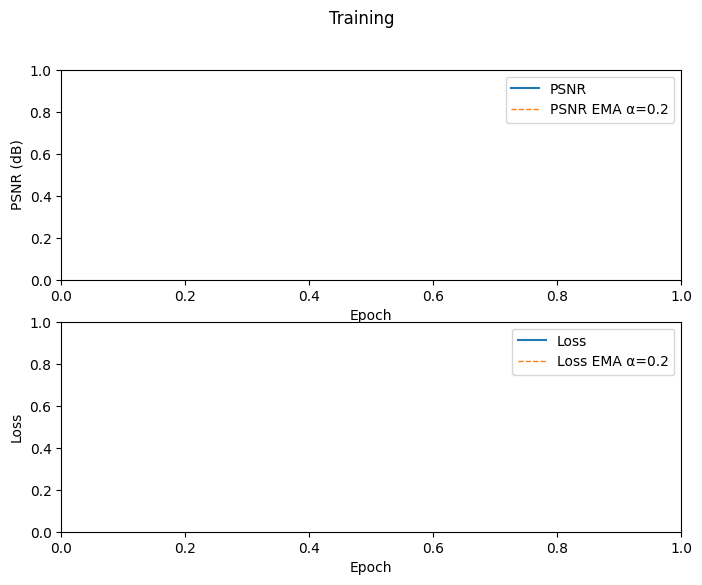

In [ ]:

import argparse, os, time, math, datetime, sys
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.multiprocessing import freeze_support
from models import *
from datasets import ImageDataset_sRGB

# from torch.optim.lr_scheduler import ReduceLROnPlateau

# --------------------- Cuda Device 선택  ---------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plotter = RealTimePlotter(title="Training", ema_alpha=0.2, max_points=100000)



def main():
    os.makedirs(f"saved_models/{opt.output_dir}", exist_ok=True)
    DEBUG_DIR = "train_samples"
    os.makedirs(DEBUG_DIR, exist_ok=True)

    # --------------------- 정규화 함수  ---------------------
    def _to01(x: torch.Tensor) -> torch.Tensor:
        # Heuristic: if outside [0,1] significantly, assume [-1,1] and map to [0,1]
        if torch.min(x).item() < -0.05 or torch.max(x).item() > 1.05:
            return ((x + 1.0) * 0.5).clamp(0.0, 1.0)
        return x.clamp(0.0, 1.0)

    #  --------------------- 평가 PSNR  ---------------------
    @torch.no_grad()
    def evaluate_psnr(forward, data_loader: DataLoader, max_batches: int = 16) -> float:
        classifier.eval()
        psnr_sum, count = 0.0, 0
        for i, batch in enumerate(data_loader):
            if i >= max_batches:
                break
            input = batch['A_input'].to(device)
            real = batch['A_target'].to(device)

            fake = forward(input)
            fake01 = _to01(fake)
            real01 = _to01(real)
            # MSE on [0,1]
            mse = F.mse_loss(fake01, real01)
            # Avoid log of zero
            psnr = 10.0 * torch.log10(1.0 / (mse + 1e-12))
            psnr_sum += psnr.item()
            count += 1
        return psnr_sum / max(1, count)

    # --------------------- Training 관련 ------------------------
    def gen_train(img_prev):
        # Classifier를 통한 가중치 추출 + softmax
        img = _to01(img_prev)
        pred = classifier(img)
        pred = F.softmax(pred, dim=1)

        # LUT에 이미지를 넣고 결과들을 추출하여 stack
        c0 = LUT0(img) # [B, 3, H, W]로 Tensor 구성
        c1 = LUT1(img)
        c2 = LUT2(img)
        

        cout = [c0, c1, c2]
        LUT_all = torch.stack(cout, dim=1) # [B, L, 3, H, W] 여기서 L은 3

        # B와 L을 Define 하기
        B, C, H, W = img.shape
        L = LUT_all.size(1) # LUT 개수

        # 가중합 처리
        out = (LUT_all * pred.view(B, L, 1, 1, 1)).sum(dim=1)

        return out

    start_epoch = 0
    if opt.epoch != 0:
        LUTs = torch.load(f"saved_models/{opt.output_dir}/LUTs_{opt.epoch}.pth")
        LUT0.load_state_dict(LUTs["0"])
        LUT1.load_state_dict(LUTs["1"])
        LUT2.load_state_dict(LUTs["2"])
        classifier.load_state_dict(torch.load(f"saved_models/{opt.output_dir}/classifier_{opt.epoch}.pth"))
        opt_state = torch.load(f"saved_models/{opt.output_dir}/optimizer_{opt.epoch}.pth", map_location=device)
        optimizer_G.load_state_dict(opt_state)
        start_epoch = opt.epoch
    else:
        classifier.apply(weights_init_normal_classifier)
        torch.nn.init.constant_(classifier.model[16].bias.data, 1.0)

    prev_time = time.time()

    for epoch in range(start_epoch, opt.n_epochs):
        classifier.train()
        loss_sum, psnr_sum = 0.0, 0.0

        for i, batch in enumerate(train_loader):
            rgb  = batch['A_input'].to(device)   # [B,3,H,W]
            real = batch['A_target'].to(device)  # [B,3,H,W]

            optimizer_G.zero_grad()

            # Forward
            fake = gen_train(rgb)     # fake: [B,3,H,W]    
            tv1, mn1 = TV3(LUT0)
            tv2, mn2 = TV3(LUT1)
            tv3, mn3 = TV3(LUT2) 
            
            tv = tv1 + tv2 + tv3
            mn = mn1 + mn2 + mn3
            

            ssim = SSIM().to(device)
            ssim_loss = ssim(_to01(fake),_to01(real)).mean()
            ciede2000_loss = delta_e00_from_srgb(_to01(fake),_to01(real)).mean()


            mse_psnr = F.mse_loss(_to01(fake), _to01(real))
            
            total_loss = opt.lambda_mse*mse_psnr + opt.lambda_smooth*tv + opt.lambda_monotonicity*mn + ssim_loss*opt.lambda_ssim + opt.lambda_color*ciede2000_loss

            # Backprop
            total_loss.backward()
            optimizer_G.step()

            # PSNR (per-batch)
            with torch.no_grad():
                psnr = 10.0 * torch.log10(1.0 / (mse_psnr + 1e-12))
                psnr_sum += psnr.item()
                loss_sum += total_loss.item()

            # ETA 표시
            batches_done = epoch * len(train_loader) + i + 1
            batches_left = opt.n_epochs * len(train_loader) - batches_done
            iter_time = time.time() - prev_time
            prev_time = time.time()
            eta = datetime.timedelta(seconds=int(batches_left * max(iter_time, 1e-9)))


            sys.stdout.write(
                f"\r[Epoch {epoch}/{opt.n_epochs}] [Batch {i+1}/{len(train_loader)}] "
                f"[psnr: {psnr_sum/(i+1):.6f}, loss: {total_loss.item():.6f}] "
                f"[mse:{mse_psnr.item():.6f}] ETA: {eta}"
            )

        # --- Validation (옵션: 간단히 train psnr 평균만 기록) ---
        avg_psnr = psnr_sum / max(1, len(train_loader))
        # Proper eval-mode PSNR using running stats (for BN) and without dropout
        eval_psnr = evaluate_psnr(gen_train, train_loader, max_batches=8)
        print(f"\n[Epoch {epoch}] train_psnr(mean): {avg_psnr:.6f} | eval_psnr: {eval_psnr:.6f} | total_loss:{total_loss:.6f}")
        plotter.update(epoch, avg_psnr, total_loss)




        # Save checkpoint
        if epoch > 0:
            LUTs = {str(i):lut.state_dict() for i,lut in enumerate([LUT0,LUT1,LUT2])}
            torch.save(LUTs, f"saved_models/{opt.output_dir}/LUTs_{epoch}.pth")
            torch.save(classifier.state_dict(), f"saved_models/{opt.output_dir}/classifier_{epoch}.pth")
            torch.save(optimizer_G.state_dict(), f"saved_models/{opt.output_dir}/optimizer_{epoch}.pth")
            with open(f"saved_models/{opt.output_dir}/result.txt","a") as f:
                f.write(f"[PSNR:{avg_psnr:.6f}] [max PSNR:{eval_psnr:.6f}, epoch:{total_loss}]\n")

            # 끝난 후 이미지로 저장하고 종료
            plotter.finalize("training_metrics.png")



if __name__ == "__main__":
    freeze_support()
    main()


## 7. Inference Code
Training이 완료되었다면, 이제 추론을 통한 결과물을 확인 후 이를 평가하는 작업을 해야하는데, 아래는 그 작업을 실행하는 코드입니다.  [0,1] 정규화를 위한 _to01 함수와 output image 도출에 필요한 gen_inference 함수가 정의되어 있으며, 바로 밑에는 inference를 진행하는 loop 및 inference 결과를 저장하는 code가 작성되어 있습니다.



In [ ]:
import os
import argparse
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from models import *
from datasets import ImageDataset_sRGB


def main():
    # Parameters
    opt = parser.parse_args()

    def _to01(x: torch.Tensor) -> torch.Tensor:
    # Heuristic: if outside [0,1] significantly, assume [-1,1] and map to [0,1]
        if torch.min(x).item() < -0.05 or torch.max(x).item() > 1.05:
            return ((x + 1.0) * 0.5).clamp(0.0, 1.0)
        return x.clamp(0.0, 1.0)



    # Cuda Device 지정 및 gradient 설정 금지 (inference이므로)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.set_grad_enabled(False)  # 전체 스크립트 no-grad

    # ===== 1) LUT 및 Classifier 불러오기  =====
    LUT0 = Generator3DLUT_identity(dim=33).to(device)
    LUT1 = Generator3DLUT_zero().to(device)
    LUT2 = Generator3DLUT_zero().to(device)
    classifier = Classifier().to(device)
    TV3 = TV_3D().to(device)

    if device == "cuda":
        LUT0 = LUT0.cuda()
        LUT1 = LUT1.cuda()
        LUT2 = LUT2.cuda()
        classifier = classifier.cuda()
        TV3 = TV3.cuda()

    LUTs = torch.load(f"saved_models/{opt.model_dir}/LUTs_{opt.inf_epoch}.pth")
    LUT0.load_state_dict(LUTs["0"])
    LUT1.load_state_dict(LUTs["1"])
    LUT2.load_state_dict(LUTs["2"])
    classifier.load_state_dict(torch.load(f"saved_models/{opt.model_dir}/classifier_{opt.inf_epoch}.pth"))


    # ===== 2) 데이터셋 =====
    root = f"data/{opt.dataset_name}"
    dataset = ImageDataset_sRGB(root, mode="test")

    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=opt.num_workers_eval,
        pin_memory=torch.cuda.is_available(),
    )
    
    # ===== 3) 출력 폴더 =====
    out_dir = os.path.join("images_new", f"{opt.model_dir}_{opt.inf_epoch}")
    os.makedirs(out_dir, exist_ok=True)
    # if opt.save_weights:
    #     os.makedirs(os.path.join(out_dir, "weights"), exist_ok=True)


    def gen_inference(img_prev):
        # Classifier를 통한 가중치 추출 + softmax
        classifier.eval()
        img = _to01(img_prev)
        pred = classifier(img)
        pred = F.softmax(pred, dim=1)  # [B, L]

        # LUT에 이미지를 넣고 결과들을 추출하여 stack
        c0 = LUT0(img) # [B, 3, H, W]로 Tensor 구성
        c1 = LUT1(img)
        c2 = LUT2(img)
        cout = [c0, c1, c2]
        LUT_all = torch.stack(cout, dim=1) # [B, L, 3, H, W] 여기서 L은 3

        # B와 L을 Define 하기
        B, C, H, W = img.shape
        L = LUT_all.size(1) # LUT 개수

        # 가중합 처리
        out = (LUT_all * pred.view(B, L, 1, 1, 1)).sum(dim=1)

        return out

    # ===== 4) 추론 루프 =====
    with torch.inference_mode():
        loss_sum, psnr_sum = 0.0, 0.0
        for batch in dataloader:
            img = batch["A_input"].to(device)# [B,3,H,W]
            real = batch["A_target"].to(device)
            name = batch["input_name"][0]
            base = os.path.splitext(name)[0] + ".png"

            # (1) LUT 통과 후 이미지 생성
            output = gen_inference(img)
            
            tv1, mn1 = TV3(LUT0)
            tv2, mn2 = TV3(LUT1)
            tv3, mn3 = TV3(LUT2) 
            
            tv = tv1 + tv2 + tv3
            mn = mn1 + mn2 + mn3
               
            mse_psnr = F.mse_loss(output, real)
            total_loss = mse_psnr + opt.lambda_smooth*tv + opt.lambda_monotonicity*mn
            
            # PSNR (per-batch)
            with torch.no_grad():
                psnr = 10.0 * torch.log10(1.0 / (mse_psnr + 1e-12))
                psnr_sum += psnr.item()
                loss_sum += total_loss.item()
            

            # (2) 저장
            save_image(output, os.path.join(out_dir, base), nrow=1, normalize=False)
    
            with open(f"{out_dir}/result.txt","a") as f:
                f.write(f"[PSNR:{psnr:.6f}] [loss:{total_loss}]\n")

    print(f"[+] Inference done. Results saved in {out_dir}")

if __name__ == "__main__":
    from multiprocessing import freeze_support
    freeze_support()  
    main()



FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/RGB_LUT_Classifier_Ckpt/LUTs_0.pth'

## 8. 수정점

원본 코드에서 많은 점들을 수정했습니다. 그 양이 점점 방대해지고 있으므로 여기에 추가적으로 기록을 남겨 이후 DB 작성에 도움이 되고자 합니다.

2025년 08월 19일까지 원본 코드에서 수정된 점 :

#### RGBNIRtoRGB Class (추가 및 수정)
    - 기존에는 RGB와 NIR 이미지를 받아, 그것을 concat한 이미지를 출력하는 단순한 Class으로써 추가되어, 4채널 입력을 3채널 R'G'B'로 바꾸어 출력하는 Class였음. (H의 조언)
    - Brightness 등을 올리는 코드 등 여러 코드들을 이 Class 내부에서 테스트함.
    - 그러나, 단순히 RGB 이미지와 NIR 이미지를 concat하니 사진의 채도, 명도와 같은 값들이 과도하게 바뀌어 합성된 사진이 단색으로 출력되는 문제가 발생.
    - 따라서, NIR 이미지에서 선택적으로 전역 통계만을 torch.functional.adaptive_avg_pool2d 함수를 이용하여 추출, 이를 RGB의 Tensor 크기에 맞추고, 이후 RGB와 수정된 NIR를 conncat 및 softmax 정규화를 이용하니 합성된 사진이 비교적 정상적으로 출력되기 시작.
    - 이후, Classifier와 3D LUT를 이용한 가중치 도출 기능 또한 통합, NIR 전역 평균을 이용한 YUV 영역에서 Y 값에 변화를 주어 output의 Brightness를 증가시키는 코드 또한 추가하여 현재에 이르게 됨.


#### TrilinearInterpolation (수정)
    - 기존의 Trilinear Interpolation Class의 경우 직접적으로 Pytorch 및 Cuda에 의존성이 매우 강한 함수라, 해당 프로그램을 구동하기 위해서는 이 Class의 수정이 필수적이었음.
    - 따라서, 현재 Pytorch 2.7.x 및 Cuda 12.1 이상 버전과 호환되게 @staticmethod 추가, .apply로 직접 Class 호출, 변수의 contiguous 보장 등과 같은 코드 문법들을 1차적으로 수정함.
    - 또한, Trilinear Interpolation 기능을 정의하고 사용하기 위한 C++/C code들인 Trilinear.cpp 내부 6개 파일의 코드들도 수정했는데, 수정 사항은 아래와 같음.
        - Pytorch 2.7.x 및 Cuda 12.1 이상 버전과 호환성을 가지게 수정, 특히, 코드들 내부에서 at::cuda::getCurrentCUDAStream() 항목을 호출하기 위한 binary가 달라졌기에, 바뀐 binary를 불러와서 이 문제를 해결함.
        - 단순히 R,G,B 3채널만을 이용하여 계산을 실행하는 기존의 코드를 수정하여, Batch를 인식하는 기능을 추가함. 따라서 [B,H,W]와 같은 형식의 Value가 들어감.
    - 중간에 시행착오가 많았으나, 기존 코드를 최대한 이용할 수 있게 수정하는 방향으로 진행함.

#### ~~Generator_3DLUT (Rollback)~~

 
#### ImageDataset_sRGB (수정)
    - NIR 이미지 input 추가, 8bit NIR image file을 float16으로 바꾸는 코드 추가(정규화), __getitem__ 에 filp 및 Crop, input image의 brightness를 무작위로 증가 혹은 감소시켜 학습 능률을 올리는 기능 추가.
    - test 모드일 경우, Target image를 참고하지 않고 Evaluation을 진행하며, train 모드일 경우 Target image를 참고하여 PSNR을 도출해내는 조건문 추가.
 
#### ~~Optimizer (rollback)~~
 
#### Training Code(수정)
    - generator_train, generator_eval, calculate_PSNR 항목 제거. 이제 이 기능들은 RGBNIRtoRGB Class에서 Generator와 Classifier의 역할을 동시에 처리.
        - 따라서, LUT를 load하는 방식 및 Checkpoint 파일을 저장하는 방식 등이 세세하게 달라짐. 기존에는 LUT, Classifier, Optimizer 등의 파일들이 각각 따로 저장되고 load 되었다면, 이젠 Generator 파일 하나로 통합하여 한 번에 Load할 수 있게 함.
    - import하는 function들이 Cuda를 지원하는 Device를 사용할 수 있도록 .to(device) 항목 추가
    - NIR image를 입력하는 필드 추가.
    - 기존에 MAX_PSNR 등을 계산하는 항목 등을 제거하는 대신, 각 Loss 값을 확인할 수 있는 항목을 추가함.
    - Loss Function을 정의하는 부분에서 하드웨어적으로 구현이 어려운 Monotonic Loss와 Smoothing Loss 항목을 제거하고, MSELoss, L1Loss, Chroma + (Entropy) 항목들로 이루어진 새로운 Loss Function을 정의함. Entropy는 Model의 LUT 사용을 균형잡히게 만들어 학습이 고르게 이루어지도록 도움. -> 추가적인 수정이 있을 수 있음.

 
#### Inference Code (수정)
    - Post processing 관련 function 2종을 추가하여, 출력의 화이트밸런스, Sharpness 등의 미세 조절을 선택할 수 있게 만들었음.
    - NIR image를 입력하는 필드 추가.



2025년 09월  03일 수정된 부분

Quadlinear Interpolation → Trilinear Interpolation으로 다시 원복 (dim 4 → 3)

- 기존의 C code들도 이에 맞게 재수정 필요 -> 백업본으로 원복.

Generator4DLUT 계열 → 3DLUT로 원복 (dim 4 → 3)

RGBNIRtoRGB 주석 처리

Dataset, Training, Inference 항목에서 NIR 입력을 더 이상 받지 않음.

기존처럼 LUT + Classifier 구성으로 갈 지, 아니면 지금처럼 Generator 구성으로 갈 지 고민이 필요 -> 더 이상 Generator가 Classifier와 LUT가 합쳐진 구성이 아님.


